In [1]:
import os
import sys
#sys.path.append('/home/manabe/.local/lib/python3.8/site-packages') #GPU使うとき無理やりパス通す←マウントオプションの変更で解決済。
#print(sys.version)
#print(sys.path)
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex, ListedColormap, Normalize
from matplotlib import ticker
import codecs
import re
import math
from tqdm import tqdm
import argparse
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import subprocess
import csv
from datetime import datetime
#sns.set(style='darkgrid')

import torch
import torch.nn as nn
from torchvision import transforms
#from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import get_info_from_filelist
import model_pool2_125hz

In [2]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=True
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'

In [3]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data, label, datatime_idx, transform=None):
        self.transform = transform
        self.data = data
        self.data_num = len(data)
        self.label = label
        self.datatime_idx = datatime_idx

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        if self.transform:
            # print(self.data.shape)
            # print(self.data[idx].shape)
            out_data = self.transform(self.data[idx])
            out_label = int(self.label[idx])
            out_datatime_idx = int(self.datatime_idx[idx])
        else:
            out_data = self.data[idx]
            out_label =  self.label[idx]
            out_datatime_idx = self.datatime_idx[idx]

        return out_data, out_label, out_datatime_idx

class ModelError(Exception):
    pass

In [4]:
def KL_Cat(q, p, eps=1e-20):
    return (q * torch.log(q+eps) - q * torch.log(p+eps)).sum()

def KL_Gauss(mu1, logvar1, mu2, logvar2):
    #return -0.5 * torch.sum(1 + (logvar1 - logvar2) - (logvar1.exp() - logvar2.exp()) - (mu2 - mu1).pow(2) / logvar2.exp())
    #return -0.5 * torch.sum(1 + logvar1 - logvar2 - logvar1.exp()/logvar2.exp() - (mu2-mu1) ** 2 / logvar2.exp())
    #return -0.5 * torch.sum(1 + logvar1 - logvar2 - mu1.pow(2) + mu2.pow(2) - logvar1.exp() + logvar2.exp())
    return -0.5 * torch.sum(1 + (logvar1 - logvar2) - (((mu2 - mu1).pow(2))) - (logvar1.exp()/logvar2.exp()))

def reconst_plot(x, recon_x, dir_out, fs, wavelet_height, wavelet_width, count, mode='train'):
    N=wavelet_width
    dt=1/fs
    for i in range(x.shape[0]):
        if count.detach().cpu().numpy()[i] == 0:
            fig = plt.figure(figsize=(1.2,1),dpi=300)
            ax=fig.add_subplot(111)
            t = np.arange(0,N+1)*dt # time array
            plt.pcolormesh(t,np.sort(np.arange(0,wavelet_height+1))[::-1], x.detach().cpu().numpy()[i][0], vmin=0,cmap='viridis')
            ax.tick_params(bottom=False,left=False,right=False,top=False)
            ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Time')
            fig.tight_layout()
            if mode == 'train':
                fig.savefig(dir_out+'train_'+str(count.detach().cpu().numpy()[i])+'.svg')
            if mode == 'test':
                fig.savefig(dir_out+'test_'+str(count.detach().cpu().numpy()[i])+'.svg')
                plt.close()

            fig = plt.figure(figsize=(1.2,1),dpi=300)
            ax=fig.add_subplot(111)
            t = np.arange(0,N+1)*dt # time array
            plt.pcolormesh(t,np.sort(np.arange(0,wavelet_height+1))[::-1], recon_x.detach().cpu().numpy()[i][0], vmin=0,cmap='viridis')
            ax.tick_params(bottom=False,left=False,right=False,top=False)
            ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Time')
            fig.tight_layout()
            if mode == 'train':
                fig.savefig(dir_out+'train_'+str(count.detach().cpu().numpy()[i])+'_recon_x.svg')
            if mode == 'test':
                fig.savefig(dir_out+'test_'+str(count.detach().cpu().numpy()[i])+'_recon_x.svg')
                plt.close()

def sample_plot(x):
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x.detach().cpu().numpy()[i][0], cmap=plt.cm.gray)
    plt.show()

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U+eps))

def gumbel_softmax_sampling(pi, shape, tau, eps=1e-20):
    log_pi = torch.log(pi + eps)
    g = sample_gumbel(shape).to(device)
    y = nn.functional.softmax((log_pi + g)/tau, dim=1)
    return y

def min_max(x, axis=None):
    """0-1の範囲に正規化"""
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

def z_plot(z,t,fig_name,epoch,DIR_OUT,Y_DIM=20):
    colors20 = plt.cm.get_cmap('tab20')
    fig = plt.figure(num=None, figsize=(4, 3), dpi=300, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    for i in range(Y_DIM):
        zplot = z[t == i]
        num = zplot.shape[0]
        c = np.full(num,i)
        sc = ax.scatter(zplot[:, 0], zplot[:, 1], s=5, c=c, cmap=colors20,norm=Normalize(vmin=0,vmax=19))
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_aspect('equal',adjustable='box')
    cbar = fig.colorbar(sc,aspect=30)
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    fig.tight_layout()
    fig.savefig(DIR_OUT+'figs/'+fig_name+'_'+str(epoch)+'.png')
    fig.savefig(DIR_OUT+'figs/'+fig_name+'_'+str(epoch)+'.svg')
    plt.close()

In [5]:
def createMydataset2D_addNoise(subject_num, test_person_num, filelist, sma_num, wavelet_height, wavelet_width, transform, distance=None, freqs_start=None, freqs_end=None):
    """ピーク前後で分割した時間軸波形をウェーブレット変換したデータを用いてデータセット作成"""

    LABELs = {}
    sub_label = 0

    peaks, min_peaks = get_info_from_filelist.count_peaks_detail(filelist, disp=False)
    # データかぶらんようにする
    min_peaks -= sma_num-1

    # 訓練データとテストデータの数を決める（8:2）
    numoftrain = int(float(min_peaks * 0.8))
    numoftest = min_peaks - numoftrain
    print(f"\n訓練データ数：{numoftrain}, テストデータ数：{numoftest}\n")

    for subject in peaks.keys():
        if subject not in LABELs:
            LABELs[subject] = sub_label
            sub_label = sub_label + 1

    print("########### 被験者とラベル ##########")
    for subject, label in LABELs.items():
        print(f"被験者：{subject},  ラベル：{label}")

    train_datasetlist = np.empty(0)
    test_datasetlist = np.empty(0)
    train_label = []
    test_label = []
    train_datatime_idx = []
    test_datatime_idx = []
    count_train = count_test = 0 #datatime_idx用

    # ファイルリスト読み込み
    filelist_fp = codecs.open(filelist, 'r')
    for _idx, filename in tqdm(enumerate(filelist_fp)):
        # ファイル読み込み
        split_fpdata = filename.rstrip('\r\n').split(',')
        #print(f"Input file: {split_fpdata[0]}")
        fname = split_fpdata[0]
    # ----- 色々正規表現で取得
        data_subject = re.findall('_([A-Z][a-z]*)_',fname)[0] #被験者 ex)Manabe
        tmp = re.findall('/(.*).npy',fname)[0]
        data_distance = re.findall('[A-Z][a-z]*_(.*)_rec',tmp)[0] #距離　ex)50cm
        #print(data_distance)
        # data_pre = int(re.findall('pre_([0-9]+)_post',fname)[0]) #ピーク前何サンプルとってるか
        is_with_breathing = True if "wo_breath" not in fname else False #呼吸ありか無しか

        if distance == None: #距離混合
            if is_with_breathing and LABELs[data_subject] < subject_num:
                data = np.load(fname)
            # ----- Create Train Dataset
                data_temp = data[:numoftrain,freqs_start:freqs_end,:]
                if freqs_start != None or freqs_end != None:
                    for i in range(data_temp.shape[0]):
                        data_temp[i] = min_max(data_temp[i])
                train_datasetlist = np.append(train_datasetlist, data_temp)
                label = [LABELs[data_subject]]*numoftrain
                train_label.extend(label)
                datatime_idx = list(range(count_train, count_train+numoftrain))
                train_datatime_idx.extend(datatime_idx)
                count_train += numoftrain

            # ----- Create Test Dataset
                data_temp = data[numoftrain+sma_num-1:min_peaks+sma_num-1,freqs_start:freqs_end,:]
                if freqs_start != None or freqs_end != None:
                    for i in range(data_temp.shape[0]):
                        data_temp[i] = min_max(data_temp[i])
                test_datasetlist = np.append(test_datasetlist, data_temp)
                label = [LABELs[data_subject]]*numoftest
                test_label.extend(label)
                #datatime_idx = list(range(numoftrain+sma_num-1,min_peaks+sma_num-1))
                datatime_idx = list(range(count_test,count_test+numoftest))
                test_datatime_idx.extend(datatime_idx)
                count_test += numoftest

            if is_with_breathing and subject_num <= LABELs[data_subject] < subject_num+test_person_num:
                data = np.load(fname)
                data_temp = data[numoftrain+sma_num-1:min_peaks+sma_num-1,freqs_start:freqs_end,:]
                if freqs_start != None or freqs_end != None:
                    for i in range(data_temp.shape[0]):
                        data_temp[i] = min_max(data_temp[i])
                test_datasetlist = np.append(test_datasetlist, data_temp)
                label = [subject_num]*numoftest
                test_label.extend(label)
                #datatime_idx = list(range(numoftrain+sma_num-1,min_peaks+sma_num-1))
                datatime_idx = list(range(count_test,count_test+numoftest))
                test_datatime_idx.extend(datatime_idx)
                count_test += numoftest

            """
            else:
            # ----- Create Test Dataset
                wo_breath_data = np.load(fname)
                npeaks = wo_breath_data.shape[0]
                test_datasetlist = np.append(test_datasetlist, wo_breath_data)
                label = [LABELs[data_subject]]*npeaks
                test_label.extend(label)
                datatime_idx = list(range(min_peaks+sma_num-1, min_peaks+sma_num-1+npeaks))
                test_datatime_idx.extend(datatime_idx)"""

        else: # 距離指定
            if is_with_breathing and data_distance == distance and LABELs[data_subject] < subject_num:
                data = np.load(fname)
            # ----- Create Train Dataset
                data_temp = data[:numoftrain,freqs_start:freqs_end,:]
                if freqs_start != None or freqs_end != None:
                    for i in range(data_temp.shape[0]):
                        data_temp[i] = min_max(data_temp[i])
                train_datasetlist = np.append(train_datasetlist, data_temp)
                label = [LABELs[data_subject]]*numoftrain
                train_label.extend(label)
                #datatime_idx = list(range(numoftrain))
                datatime_idx = list(range(count_train, count_train+numoftrain))
                train_datatime_idx.extend(datatime_idx)
                count_train += numoftrain

            # ----- Create Test Dataset
                
                data_temp = data[numoftrain+sma_num-1:min_peaks+sma_num-1,freqs_start:freqs_end,:]
                if freqs_start != None or freqs_end != None:
                    for i in range(data_temp.shape[0]):
                        data_temp[i] = min_max(data_temp[i])
                test_datasetlist = np.append(test_datasetlist, data_temp)
                label = [LABELs[data_subject]]*numoftest
                test_label.extend(label)
                #datatime_idx = list(range(numoftrain+sma_num-1,min_peaks+sma_num-1))
                datatime_idx = list(range(count_test, count_test+numoftest))
                test_datatime_idx.extend(datatime_idx)
                count_test += numoftest
            
            if is_with_breathing and data_distance == distance and subject_num<=LABELs[data_subject]<subject_num+test_person_num:
                data = np.load(fname)
                data_temp = data[numoftrain+sma_num-1:min_peaks+sma_num-1,freqs_start:freqs_end,:]
                if freqs_start != None or freqs_end != None:
                    for i in range(data_temp.shape[0]):
                        data_temp[i] = min_max(data_temp[i])
                test_datasetlist = np.append(test_datasetlist, data_temp)
                label = [subject_num]*numoftest
                test_label.extend(label)
                datatime_idx = list(range(count_test,count_test+numoftest))
                test_datatime_idx.extend(datatime_idx)
                count_test += numoftest

            """
            elif data_distance == distance:
            # ----- Create Test Dataset
                wo_breath_data = np.load(fname)
                npeaks = wo_breath_data.shape[0]
                test_datasetlist = np.append(test_datasetlist, wo_breath_data)
                label = [LABELs[data_subject]]*npeaks
                test_label.extend(label)
                datatime_idx = list(range(min_peaks+sma_num-1, min_peaks+sma_num-1+npeaks))
                test_datatime_idx.extend(datatime_idx)"""
    
    # 訓練データに「ノイズ」クラスを追加
    
    num_per_one = int(len(train_label)/subject_num)
    noise_dataset = np.random.rand(num_per_one,wavelet_height,wavelet_width)
    for i in range(noise_dataset.shape[0]):
        noise_dataset[i] = min_max(noise_dataset[i])
    label = [subject_num]*num_per_one
    datatime_idx = [0]*num_per_one
    
    train_datasetlist = np.append(train_datasetlist, noise_dataset)
    train_label.extend(label)
    train_datatime_idx.extend(datatime_idx)

    # データ成型
    train_datasetlist = np.reshape(train_datasetlist, (-1, wavelet_height, wavelet_width, 1))
    test_datasetlist = np.reshape(test_datasetlist, (-1, wavelet_height, wavelet_width, 1))
    print(f"train_datasetlist.shape : {train_datasetlist.shape}")
    print(f"test_datasetlist.shape : {test_datasetlist.shape}")

    train_label = np.array(train_label)
    test_label = np.array(test_label)
    print(f"train_label.shape : {train_label.shape}")
    print(f"test_label.shape : {test_label.shape}")
    print(f"train_label : {train_label}")

    train_datatime_idx = np.array(train_datatime_idx)
    test_datatime_idx = np.array(test_datatime_idx)
    print(f"train_datatime_idx：{train_datatime_idx.shape}")
    print(f"test_datatime_idx：{test_datatime_idx.shape}")

    filelist_fp.close()

    return MyDataset(train_datasetlist.astype(np.float32), train_label, train_datatime_idx, transform), MyDataset(test_datasetlist.astype(np.float32), test_label, test_datatime_idx, transform)

In [6]:
def train(K,pz_y,px_z,qy_x,qz_xy,train_loader,optimizer,ALPHA,BETA,device,epoch,DIR_OUT):
    pz_y.train()
    px_z.train()
    qy_x.train()
    qz_xy.train()

    total_loss = total_recon_loss = total_kl_gauss = total_Xent = 0.0
    t_list = []
    y_list = []
    z_xy_list = []
    z_y_list = []

    for x, t, _ in train_loader:
        x = x.to(device)
        t = t.to(device)
    # ----- クロスエントロピー項
        y = qy_x(x)
        Xent = nn.functional.cross_entropy(y, t, reduction="sum")
    # ----- 再構性項
        t_onehot = torch.eye(K)[t].to(device)
        z = qz_xy(x, t_onehot)
        recon_x = px_z(z)
        recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    # ----- Prior Network Loss
        z_y = pz_y(t_onehot)
        kl_gauss = KL_Gauss(qz_xy.mu, qz_xy.logvar, pz_y.mu, pz_y.logvar)

        loss = recon_loss + kl_gauss*BETA + Xent*ALPHA
        total_loss += loss
        total_recon_loss += recon_loss
        total_kl_gauss += kl_gauss
        total_Xent += Xent

        y = y.argmax(dim=1).detach().cpu().numpy()
        t = t.detach().cpu().numpy()
        z = z.detach().cpu().numpy()
        z_y = z_y.detach().cpu().numpy()

        y_list.extend(y)
        t_list.extend(t)
        z_xy_list.extend(z)
        z_y_list.extend(z_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_gauss = total_kl_gauss / len(train_loader.dataset)
    avg_Xent = total_Xent / len(train_loader.dataset)
    y_array = np.array(y_list)
    t_array = np.array(t_list)
    avg_precision = precision_score(t_array,y_array,average='macro',zero_division=0)
    avg_recall = recall_score(t_array,y_array,average='macro',zero_division=0)
    avg_f1 = f1_score(t_array,y_array,average='macro',zero_division=0)

    z_xy_array = np.array(z_xy_list)
    z_y_array = np.array(z_y_list)
    #z_plot(z_xy_array,t_array,'qz_xy',epoch,DIR_OUT)
    #z_plot(z_y_array,t_array,'pz_y',epoch,DIR_OUT)

    return avg_loss, avg_recon_loss, avg_kl_gauss, avg_Xent, avg_precision, avg_recall, avg_f1

def test(K,pz_y,px_z,qy_x,qz_xy,dataloader,ALPHA,BETA,device):
    #K=K+1
    pz_y.eval()
    px_z.eval()
    qy_x.eval()
    qz_xy.eval()

    with torch.no_grad():
        total_loss = total_recon_loss = total_kl_gauss = total_Xent = 0.0
        t_list = []
        y_list = []

        for x, t, _ in dataloader:
            x = x.to(device)
            t = t.to(device)
        # ----- クロスエントロピー項
            y = qy_x(x)
            Xent = nn.functional.cross_entropy(y, t, reduction="sum")
        # ----- 再構性項
            t_onehot = torch.eye(K)[t].to(device)
            z = qz_xy(x, y)
            recon_x = px_z(z)
            recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
        # ----- Prior Network Loss
            pz_y(t_onehot)
            kl_gauss = KL_Gauss(qz_xy.mu, qz_xy.logvar, pz_y.mu, pz_y.logvar)

            loss = recon_loss + kl_gauss*BETA + Xent*ALPHA
            total_loss += loss
            total_recon_loss += recon_loss
            total_kl_gauss += kl_gauss
            total_Xent += Xent

            y = y.argmax(dim=1).detach().cpu().numpy()
            t = t.detach().cpu().numpy()
            y_list.extend(y)
            t_list.extend(t)

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_gauss = total_kl_gauss / len(dataloader.dataset)
    avg_Xent = total_Xent / len(dataloader.dataset)
    y_array = np.array(y_list)
    t_array = np.array(t_list)
    avg_precision = precision_score(t_array,y_array,average='macro',zero_division=0)
    avg_recall = recall_score(t_array,y_array,average='macro',zero_division=0)
    avg_f1 = f1_score(t_array,y_array,average='macro',zero_division=0)

    return avg_loss, avg_recon_loss, avg_kl_gauss, avg_Xent, avg_precision, avg_recall, avg_f1

def do_train_and_test(K,pz_y,px_z,qy_x,qz_xy,train_loader,test_loader,optimizer,epoch_num,device,ALPHA,BETA,DIR_OUT):
    history = {}
    history['train_loss'] = []
    history['train_recon_loss'] = []
    history['train_kl_gauss'] = []
    history['train_Xent'] = []
    history['train_precision'] = []
    history['train_recall'] = []
    history['train_f1'] = []

    history['test_loss'] = []
    history['test_recon_loss'] = []
    history['test_kl_gauss'] = []
    history['test_Xent'] = []
    history['test_precision'] = []
    history['test_recall'] = []
    history['test_f1'] = []

    for epoch in tqdm(range(epoch_num)):
        train_loss,train_recon_loss,train_kl_gauss,train_Xent,train_precision,train_recall,train_f1 = train(K+1,pz_y,px_z,qy_x,qz_xy,train_loader,optimizer,ALPHA,BETA,device,epoch,DIR_OUT)
        test_loss,test_recon_loss,test_kl_gauss,test_Xent,test_precision,test_recall,test_f1 = test(K+1,pz_y,px_z,qy_x,qz_xy,test_loader,ALPHA,BETA,device)
        history['train_loss'].append(train_loss)
        history['train_recon_loss'].append(train_recon_loss)
        history['train_kl_gauss'].append(train_kl_gauss)
        history['train_Xent'].append(train_Xent)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        history['test_loss'].append(test_loss)
        history['test_recon_loss'].append(test_recon_loss)
        history['test_kl_gauss'].append(test_kl_gauss)
        history['test_Xent'].append(test_Xent)
        history['test_precision'].append(test_precision)
        history['test_recall'].append(test_recall)
        history['test_f1'].append(test_f1)
    return history

def plot_every_epoch(values1,values2,rng,label1,label2,ylabel,savefig_path,bbox_to_anchor=(1,1),loc='center right'):
    fig = plt.figure(figsize=(2.5,2),dpi=300)
    ax = fig.add_subplot(111)
    ax.plot(range(rng),values1,label=label1)
    ax.plot(range(rng),values2,label=label2)
    ax.legend(bbox_to_anchor=bbox_to_anchor,loc=loc,borderaxespad=0)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    plt.savefig(savefig_path,bbox_inches='tight',pad_inches=0.05)
    plt.close()

In [7]:
def main(args):

# ----- パラメータ設定
    DISTANCE = args.distance
    Z_DIM = args.z_dim
    K = Y_DIM = args.y_dim
    IS_SUPERVISED = args.disable_supervised
    EPOCH_NUM = args.epoch_num #200
    TAU = args.tau # 温度
    BETA = args.beta #7 kl_gaussの係数
    ALPHA = args.alpha #1000 Xentの係数
    SEED = args.seed
    BATCH_SIZE = args.batch_size
    LR = args.lr # 学習率
    SMA_NUM = args.sma_num
    TEST_PERSON_NUM = args.test_person_num
    WAVELET_HEIGHT = args.wavelet_height
    WAVELET_WIDTH = args.wavelet_width
    PLOT_RECON = args.plot_recon
    FREQS_START = args.freqs_start
    FREQS_END = args.freqs_end
    FS = args.fs
    POOL = args.pool
    YULE = args.yule

# ----- データ入出力するディレクトリ
    PARENT_DIR_OUT = args.pardir
    if DISTANCE == None:
        CHILD_DIR_OUT = 'sma'+str(SMA_NUM)+'_zdim'+str(Z_DIM)+'_pool'+str(POOL)+'_epoch'+str(EPOCH_NUM)+'_ydim'+str(Y_DIM)+'/'
    else:
        CHILD_DIR_OUT = 'sma'+str(SMA_NUM)+'_zdim'+str(Z_DIM)+'_pool'+str(POOL)+'_'+DISTANCE+'_epoch'+str(EPOCH_NUM)+'_ydim'+str(Y_DIM)+'/'
    DIR_OUT = PARENT_DIR_OUT + CHILD_DIR_OUT

    FILELIST_DIR = args.filelist_dir
    FLISTNAME_IN = args.flistname_in
    FILELIST_IN_PATH = FILELIST_DIR + FLISTNAME_IN

    if not os.path.exists(PARENT_DIR_OUT):
        os.mkdir(PARENT_DIR_OUT)
    if not os.path.exists(DIR_OUT):
        os.mkdir(DIR_OUT)

    if PLOT_RECON and not os.path.exists(DIR_OUT+'figs/'):
        os.mkdir(DIR_OUT+'figs/')

    if not os.path.exists(FILELIST_DIR):
        os.mkdir(FILELIST_DIR)


    #K = Y_DIM = get_info_from_filelist.get_y_dim(FILELIST)
    print("########## パラメータ ##########")
    print(f"Z_DIM = {Z_DIM}\nK = Y_DIM = {K}\nIS_SUPERVISED = {IS_SUPERVISED}\nepoch_num = {EPOCH_NUM}\ntau = {TAU}\nbeta = {BETA} kl_gaussの係数\nalpha = {ALPHA} Xentの係数\nbatch_size = {BATCH_SIZE}\nlr = {LR}\nsma_num = {SMA_NUM}\nfs = {FS}\npool = {POOL}")
    print("###############################")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

# ----- データセット作成
    print('ファイル読み込み...')
    transform = transforms.Compose([transforms.ToTensor()])
    #train_dataset, _test_dataset = createMydataset2D(Y_DIM,FILELIST_IN_PATH, SMA_NUM, WAVELET_HEIGHT, WAVELET_WIDTH, transform, DISTANCE, FREQS_START, FREQS_END)
    #noise_dataset = createNoiseDataset(34*9,WAVELET_HEIGHT,WAVELET_WIDTH,transform)
    #train_dataset = MyDataset(np.concatenate([train_dataset.data,noise_dataset.data],0).astype(np.float32),
    #                    np.concatenate([train_dataset.label,noise_dataset.label],0),
    #                    np.concatenate([train_dataset.datatime_idx,noise_dataset.datatime_idx],0).astype(np.float32))
    #_, test_dataset = createMydataset2D(5,FILELIST_IN_PATH, SMA_NUM, WAVELET_HEIGHT, WAVELET_WIDTH, transform, DISTANCE, FREQS_START, FREQS_END)

    train_dataset, test_dataset = createMydataset2D_addNoise(Y_DIM, TEST_PERSON_NUM, FILELIST_IN_PATH, SMA_NUM, WAVELET_HEIGHT, WAVELET_WIDTH, transform, DISTANCE, FREQS_START, FREQS_END)

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

# ----- ネットワークモデル
    if YULE and FS == 125 and POOL == 2:
        px_z = model_yule_pool2_125hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_yule_pool2_125hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_yule_pool2_125hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_yule_pool2_125hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    elif YULE and FS == 125 and POOL == 4:
        px_z = model_yule_pool4_125hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_yule_pool4_125hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_yule_pool4_125hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_yule_pool4_125hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    elif YULE and FS == 500 and POOL == 2:
        px_z = model_yule_pool2_500hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_yule_pool2_500hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_yule_pool2_500hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_yule_pool2_500hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    elif YULE and FS == 500 and POOL == 4:
        px_z = model_yule_pool4_500hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_yule_pool4_500hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_yule_pool4_500hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_yule_pool4_500hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    elif FS == 125 and POOL == 2:
        print("model")
        px_z = model_pool2_125hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_pool2_125hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM+1).to(device)
        qy_x = model_pool2_125hz.Qy_x(y_dim=Y_DIM+1).to(device)
        qz_xy = model_pool2_125hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM+1).to(device)
    elif FS == 125 and POOL == 4:
        px_z = model_pool4_125hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_pool4_125hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_pool4_125hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_pool4_125hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    elif FS == 500 and POOL == 2:
        px_z = model_pool2_500hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_pool2_500hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_pool2_500hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_pool2_500hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    elif FS == 500 and POOL == 4:
        px_z = model_pool4_500hz.Px_z(z_dim=Z_DIM).to(device)
        pz_y = model_pool4_500hz.Pz_y(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
        qy_x = model_pool4_500hz.Qy_x(y_dim=Y_DIM).to(device)
        qz_xy = model_pool4_500hz.Qz_xy(z_dim=Z_DIM, y_dim=Y_DIM).to(device)
    else:
        raise ModelError('nn.MaxPool2d()のカーネルサイズかサンプリングレート非対応')

    optimizer = torch.optim.Adam(list(px_z.parameters())+list(pz_y.parameters())
        +list(qy_x.parameters())+list(qz_xy.parameters()), lr=LR)

    #validation、一応準備してるけど使ってない
    # train_size = int(len(train_dataset) * 0.9)
    # val_size = len(train_dataset) - train_size
    # train_dataset_s, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    # train_loader = DataLoader(
    #     dataset=train_dataset_s, BATCH_SIZE=128, shuffle=True)
    # test_loader = DataLoader(
    #     dataset=val_dataset, BATCH_SIZE=128, shuffle=True)

    train_loader = DataLoader(
        dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    history = do_train_and_test(K,pz_y,px_z,qy_x,qz_xy,train_loader,test_loader,optimizer,EPOCH_NUM,device,ALPHA,BETA,DIR_OUT)
    #values1,values2,rng,label1,label2,ylabel,savefig_path,bbox_to_anchor=(1,1),loc='center right'):
    """
    plot_every_epoch(history['train_loss'],history['test_loss'],EPOCH_NUM,'train','test','Loss',DIR_OUT+'loss.svg',loc='upper right')
    plot_every_epoch(history['train_recon_loss'],history['test_recon_loss'],EPOCH_NUM,'train','test','$\mathcal{L}_{RC}$',DIR_OUT+'loss_rc.svg',loc='upper right')
    plot_every_epoch(history['train_kl_gauss'],history['test_kl_gauss'],EPOCH_NUM,'train','test','$\mathcal{L}_{KL}$',DIR_OUT+'loss_kl.svg',loc='upper right')
    plot_every_epoch(history['train_Xent'],history['test_Xent'],EPOCH_NUM,'train','test','$\mathcal{L}_{CE}$',DIR_OUT+'loss_ce.svg',loc='upper right')
    plot_every_epoch(history['train_precision'],history['test_precision'],EPOCH_NUM,'train','test','Precision',DIR_OUT+'score_precision.svg',bbox_to_anchor=(1,0),loc='lower right')
    plot_every_epoch(history['train_recall'],history['test_recall'],EPOCH_NUM,'train','test','Recall',DIR_OUT+'score_recall.svg',bbox_to_anchor=(1,0),loc='lower right')
    plot_every_epoch(history['train_f1'],history['test_f1'],EPOCH_NUM,'train','test','F-measure',DIR_OUT+'score_f1.svg',bbox_to_anchor=(1,0),loc='lower right')

    plot_every_epoch(history['train_loss'],history['test_loss'],EPOCH_NUM,'train','test','Loss',DIR_OUT+'loss.png',loc='upper right')
    plot_every_epoch(history['train_recon_loss'],history['test_recon_loss'],EPOCH_NUM,'train','test','$\mathcal{L}_{RC}$',DIR_OUT+'loss_rc.png',loc='upper right')
    plot_every_epoch(history['train_kl_gauss'],history['test_kl_gauss'],EPOCH_NUM,'train','test','$\mathcal{L}_{KL}$',DIR_OUT+'loss_kl.png',loc='upper right')
    plot_every_epoch(history['train_Xent'],history['test_Xent'],EPOCH_NUM,'train','test','$\mathcal{L}_{CE}$',DIR_OUT+'loss_ce.png',loc='upper right')
    plot_every_epoch(history['train_precision'],history['test_precision'],EPOCH_NUM,'train','test','Precision',DIR_OUT+'score_precision.png',bbox_to_anchor=(1,0),loc='lower right')
    plot_every_epoch(history['train_recall'],history['test_recall'],EPOCH_NUM,'train','test','Recall',DIR_OUT+'score_recall.png',bbox_to_anchor=(1,0),loc='lower right')
    plot_every_epoch(history['train_f1'],history['test_f1'],EPOCH_NUM,'train','test','F-measure',DIR_OUT+'score_f1.png',bbox_to_anchor=(1,0),loc='lower right')
    """
    fig = plt.figure(figsize=(4.5,2),dpi=300)
    ax = fig.add_subplot(111)
    ax.plot(range(EPOCH_NUM),history['train_loss'],label='Train Loss')
    ax.plot(range(EPOCH_NUM),history['test_loss'],label='Test Loss',color='tab:blue',linestyle=':')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    plt.grid(b=False)
    handle1, label1 = ax.get_legend_handles_labels()
    ax = ax.twinx()
    ax.plot(range(EPOCH_NUM),history['train_f1'],label='Train Accuracy',color='tab:orange')
    ax.plot(range(EPOCH_NUM),history['test_f1'],label='Test Accuracy',color='tab:orange',linestyle=':')
    ax.spines['right'].set_color('tab:orange')
    ax.tick_params(axis='y',colors='tab:orange')
    handle2, label2 = ax.get_legend_handles_labels()
    ax.legend(handle1+handle2,label1+label2,bbox_to_anchor=(1.2,0.5),loc=6)
    ax.set_ylabel('Accuracy',color='tab:orange')
    fig.tight_layout()
    plt.grid(b=False)
    plt.savefig(DIR_OUT+'loss_acc.png',bbox_inches='tight',pad_inches=0.05)
    plt.savefig(DIR_OUT+'loss_acc.svg',bbox_inches='tight',pad_inches=0.05)
    subprocess.call('inkscape -M '+DIR_OUT+'loss_acc.emf '+DIR_OUT+'loss_acc.svg',shell=True)
    plt.close()
    #lossをプロット＆ファイル出力したいので準備する。
    """
    t = np.arange(0,EPOCH_NUM)
    loss_list = []
    recon_loss_list = []
    kl_cat_list = []
    kl_gauss_list = []
    if IS_SUPERVISED:
        Xent_list = []

    for epoch in tqdm(range(EPOCH_NUM)):

        if IS_SUPERVISED:
            loss = train(K,pz_y,px_z,qy_x,qz_xy,train_loader,loss_list,recon_loss_list,kl_gauss_list,Xent_list,optimizer,ALPHA,BETA,device)


        else:
            for x, _ in train_loader:
                x = x.to(device)
                pi = qy_x(x)
                y = gumbel_softmax_sampling(pi, shape=pi.shape, tau=TAU)
                z = qz_xy(x, y)
                recon_x = px_z(z)
                recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")

                pi_prior = (torch.ones(K)/K).to(device)
                kl_cat = KL_Cat(pi, pi_prior)
                pz_y(y)
                kl_gauss = KL_Gauss(qz_xy.mu, qz_xy.logvar, pz_y.mu, pz_y.logvar)
                loss = recon_loss + kl_cat + kl_gauss*BETA

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss_list.append(loss)
            recon_loss_list.append(recon_loss)
            kl_cat_list.append(kl_cat)
            kl_gauss_list.append(kl_gauss)

    #loss plot
    fig = plt.figure(figsize=(10,5))
    if IS_SUPERVISED:
        ax = fig.add_subplot(141)
        ax.plot(t,loss_list)
        ax.set_title("Loss")
        ax = fig.add_subplot(142)
        ax.plot(t,recon_loss_list)
        ax.set_title("recon_loss")
        ax = fig.add_subplot(143)
        ax.plot(t,kl_gauss_list)
        ax.set_title("kl_gauss")
        ax = fig.add_subplot(144)
        ax.plot(t,Xent_list)
        ax.set_title("cross_entropy")
        loss_ndarray = np.vstack((np.array(loss_list),np.array(recon_loss_list),np.array(kl_gauss_list),np.array(Xent_list)))
    else:
        ax = fig.add_subplot(141)
        ax.plot(t,loss_list)
        ax.set_title("Loss")
        ax = fig.add_subplot(142)
        ax.plot(t,recon_loss_list)
        ax.set_title("recon_loss")
        ax = fig.add_subplot(143)
        ax.plot(t,kl_cat_list)
        ax.set_title("kl_cat")
        ax = fig.add_subplot(144)
        ax.plot(t,kl_gauss_list)
        ax.set_title("kl_gauss")
        loss_ndarray = np.vstack((np.array(loss_list),np.array(recon_loss_list),np.array(kl_cat_list),np.array(kl_gauss_list)))
    fig.savefig(DIR_OUT+'loss_2d_sma'+str(SMA_NUM)+'.png')
    np.savetxt(DIR_OUT+'loss_sma'+str(SMA_NUM)+'.csv',loss_ndarray,delimiter=',')"""

    ### 12/04追記 推論モードでcpu使う ###
    device = torch.device("cpu")
    print(device)

    #学習結果を一旦保存
    torch.save(px_z.state_dict(), DIR_OUT+'px_z.pth')
    torch.save(pz_y.state_dict(), DIR_OUT+'pz_y.pth')
    torch.save(qy_x.state_dict(), DIR_OUT+'qy_x.pth')
    torch.save(qz_xy.state_dict(), DIR_OUT+'qz_xy.pth')

    #学習結果を読み込んで、
    px_z.load_state_dict(torch.load(DIR_OUT+'px_z.pth', map_location=lambda storage, loc: storage))
    pz_y.load_state_dict(torch.load(DIR_OUT+'pz_y.pth', map_location=lambda storage, loc: storage))
    qy_x.load_state_dict(torch.load(DIR_OUT+'qy_x.pth', map_location=lambda storage, loc: storage))
    qz_xy.load_state_dict(torch.load(DIR_OUT+'qz_xy.pth', map_location=lambda storage, loc: storage))
    #推論モードに設定（Dropout、BN、他の無効化）.to(device)は12/04追加。
    px_z.eval().to(device)
    pz_y.train().to(device)
    qy_x.eval().to(device)
    qz_xy.train().to(device)
    print(f"qz_xy.training:{qz_xy.training}(trueなら学習モード/falseなら推論モード)")

    colors = plt.cm.get_cmap('hsv')
    colors20 = plt.cm.get_cmap('tab20')
    cmap = cm.get_cmap('hsv',21)
    color_code = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        color_code.append(rgb2hex(rgb))

    cmap = ListedColormap(color_code)
    bounds = list(range(0,21))
    #norm = BoundaryNorm(bounds, cmap.N)

    # ノイズ用に1クラス追加
    K += 1
    Y_DIM += 1

    ltrain_pred = []
    ztrain_pred = []
    train_datatime_idx = []
    #2021.2.5追記 qy_xによる予測も出力
    ltrain_qy_x = []
    ztrain_pz_y = []
    #count=0
    for x, t, datatime_idx in train_loader:
        #print(datatime_idx.detach().cpu().numpy())
        x = x.to(device)
        y = qy_x(x)
        with torch.no_grad():
            z = qz_xy(x, y)
        y_label_onehot = torch.eye(K)[t].to(device)
        with torch.no_grad():
            pz_y_out = pz_y(y_label_onehot) #この分布にqz_xyを近づけようと学習していたはず

        #print(f"y[0]:{y[0]}")
        if PLOT_RECON:
            recon_x_train = px_z(z) # reconstruction
            #print(f"recon_x_train.shape : {recon_x_train.shape}")
            #reconst_plot(x,recon_x_train,DIR_OUT+'figs/',125,WAVELET_HEIGHT,WAVELET_WIDTH,BATCH_SIZE,count,mode='train')
            reconst_plot(x,recon_x_train,DIR_OUT+'figs/',125,WAVELET_HEIGHT,WAVELET_WIDTH,datatime_idx,mode='train')
        ztrain_pred.extend(z.detach().cpu().numpy())
        ltrain_pred.extend(t.numpy())
        train_datatime_idx.extend(datatime_idx.numpy())
        ltrain_qy_x.extend(y.argmax(dim=1).numpy()) #2021.2.5
        ztrain_pz_y.extend(pz_y_out.detach().cpu().numpy())
        #count += 1
    ltrain_pred = np.array(ltrain_pred)
    ztrain_pred = np.array(ztrain_pred)
    train_datatime_idx = np.array(train_datatime_idx)
    ltrain_qy_x = np.array(ltrain_qy_x)
    ztrain_pz_y = np.array(ztrain_pz_y)

    ltest_pred = []
    ztest_pred = []
    test_datatime_idx = []
    #2021.2.5追記 qy_xによる予測も出力
    ltest_qy_x = []
    count=0
    for x, t, datatime_idx in test_loader:
        x = x.to(device)
        y = qy_x(x)
        with torch.no_grad():
            z = qz_xy(x, y)
        if PLOT_RECON:
            recon_x_test = px_z(z)
            #reconst_plot(x,recon_x_test,DIR_OUT+'figs/',125,WAVELET_HEIGHT,WAVELET_WIDTH,BATCH_SIZE,count,mode='test')
            reconst_plot(x,recon_x_test,DIR_OUT+'figs/',125,WAVELET_HEIGHT,WAVELET_WIDTH,datatime_idx,mode='test')
        ztest_pred.extend(z.detach().cpu().numpy())
        ltest_pred.extend(t.numpy())
        test_datatime_idx.extend(datatime_idx.numpy())
        ltest_qy_x.extend(y.argmax(dim=1).numpy()) #2021.2.5
        count += 1
    ltest_pred = np.array(ltest_pred)
    ztest_pred = np.array(ztest_pred)
    test_datatime_idx = np.array(test_datatime_idx)
    ltest_qy_x = np.array(ltest_qy_x)

    test_accuracy = accuracy_score(ltest_pred,ltest_qy_x)
    if not os.path.isfile(DIR_OUT+'accuracy_score.csv'):
        with open(DIR_OUT+'accuracy_score.csv',mode='w',newline='') as f:
            dt_now = datetime.now()
            writer = csv.writer(f)
            writer.writerow([str(test_accuracy), dt_now.strftime('%Y-%m-%d %H:%M:%S')])
    else:
        with open(DIR_OUT+'accuracy_score.csv',mode='a',newline='') as f:
            dt_now = datetime.now()
            writer = csv.writer(f)
            writer.writerow([str(test_accuracy), dt_now.strftime('%Y-%m-%d %H:%M:%S')])

# ----- 2021.2.5 p(z|y)の分布をプロット
    fig = plt.figure(num=None, figsize=(4, 3), dpi=300, facecolor='w', edgecolor='k')
    subxy = 2 if Z_DIM > 2 else 1
    ax = plt.subplot(subxy, subxy, 1)
    for i in range(Y_DIM):
        zplot = ztrain_pz_y[ltrain_pred == i]
        #ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
        #sc = ax.scatter(zplot[:, 0], zplot[:, 1], s=5, c=c, cmap=colors20,norm=norm,vmin=min(bounds),vmax=max(bounds))
        num = zplot.shape[0]
        c = np.full(num,i)
        sc = ax.scatter(zplot[:, 0], zplot[:, 1], s=5, c=c, cmap=colors20,norm=Normalize(vmin=0,vmax=19))
        #zplot = np.vstack((zplot[:,0],zplot[:,1])).T
        #zavg = zplot.sum(axis=0)/zplot.shape[0]
        #ax.annotate(str(i),zavg)
        #zplot = ztest_pred[ltest_pred == i]
        #ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, c=colors[i + Y_DIM])
        #plt.legend()
    ax.set_xlim(-4.5,4.5)
    ax.set_ylim(-4.5,4.5)
    ax.set_aspect('equal',adjustable='box')
    cbar = fig.colorbar(sc,aspect=30)
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    if Z_DIM > 2:
        ax = plt.subplot(subxy, subxy, 2)
        for i in range(Y_DIM):
            zplot = ztrain_pz_y[ltrain_pred == i]
            ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i,color=colors(2*i/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,0],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            #zplot = ztest_pred[ltest_pred == i]
            #ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i, c=colors[i + Y_DIM])
            plt.legend()
        ax = plt.subplot(subxy, subxy, 3)
        for i in range(Y_DIM):
            zplot = ztrain_pz_y[ltrain_pred == i]
            ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,1],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            #zplot = ztest_pred[ltest_pred == i]
            #ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, c=colors[i + Y_DIM])
            plt.legend()
    fig.tight_layout()
    fig.savefig(DIR_OUT+"Qz_y.png")
    """
    fig = plt.figure(num=None, figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
    subxy = 2 if Z_DIM > 2 else 1
    print(f"Z_DIM:{Z_DIM}, subxy:{subxy}")
    ax = plt.subplot(subxy, subxy, 1)
    for i in range(Y_DIM):
        zplot = ztrain_pred[ltrain_pred == i]
        ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
        zplot = np.vstack((zplot[:,0],zplot[:,1])).T
        zavg = zplot.sum(axis=0)/zplot.shape[0]
        ax.annotate(str(i),zavg)
        zplot = ztest_pred[ltest_pred == i]
        ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, color=colors((2*i+1)/(Y_DIM*2)))
        #plt.legend()
    if Z_DIM > 2:
        ax = plt.subplot(subxy, subxy, 2)
        for i in range(Y_DIM):
            zplot = ztrain_pred[ltrain_pred == i]
            ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,0],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            zplot = ztest_pred[ltest_pred == i]
            ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i, color=colors((2*i+1)/(Y_DIM*2)))
            plt.legend()
        ax = plt.subplot(subxy, subxy, 3)
        for i in range(Y_DIM):
            zplot = ztrain_pred[ltrain_pred == i]
            ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,1],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            zplot = ztest_pred[ltest_pred == i]
            ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, color=colors((2*i+1)/(Y_DIM*2)))
            plt.legend()
    fig.tight_layout()
    fig.savefig(DIR_OUT+"VAEclustering_2d_sma"+str(SMA_NUM)+".png")"""

    fig2 = plt.figure(num=None, figsize=(4, 3), dpi=300, facecolor='w', edgecolor='k')
    subxy = 2 if Z_DIM > 2 else 1
    ax = plt.subplot(subxy, subxy, 1)
    for i in range(Y_DIM):
        zplot = ztrain_pred[ltrain_pred == i]
        """ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
        zplot = np.vstack((zplot[:,0],zplot[:,1])).T
        zavg = zplot.sum(axis=0)/zplot.shape[0]
        ax.annotate(str(i),zavg)"""
        num = zplot.shape[0]
        c = np.full(num,i)
        sc = ax.scatter(zplot[:, 0], zplot[:, 1], s=5, c=c, cmap=colors20,norm=Normalize(vmin=0,vmax=19))
        #zplot = ztest_pred[ltest_pred == i]
        #ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, c=colors[i + Y_DIM])
        #plt.legend()
    ax.set_xlim(-4.5,4.5)
    ax.set_ylim(-4.5,4.5)
    ax.set_aspect('equal',adjustable='box')
    cbar = fig2.colorbar(sc,aspect=30)
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    if Z_DIM > 2:
        ax = plt.subplot(subxy, subxy, 2)
        for i in range(Y_DIM):
            zplot = ztrain_pred[ltrain_pred == i]
            ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i,color=colors(2*i/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,0],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            #zplot = ztest_pred[ltest_pred == i]
            #ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i, c=colors[i + Y_DIM])
            plt.legend()
        ax = plt.subplot(subxy, subxy, 3)
        for i in range(Y_DIM):
            zplot = ztrain_pred[ltrain_pred == i]
            ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, color=colors(2*i/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,1],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            #zplot = ztest_pred[ltest_pred == i]
            #ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, c=colors[i + Y_DIM])
            plt.legend()
    fig2.tight_layout()
    fig2.savefig(DIR_OUT+"VAEclustering_2d_train_sma"+str(SMA_NUM)+".png")

    fig3 = plt.figure(num=None, figsize=(4, 3), dpi=300, facecolor='w', edgecolor='k')
    subxy = 2 if Z_DIM > 2 else 1
    #print(f"Y_DIM{Z_DIM}, subxy{subxy}")
    ax = plt.subplot(subxy, subxy, 1)
    for i in range(Y_DIM):
        #zplot = ztrain_pred[ltrain_pred == i]
        #ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, c=colors[i])
        zplot = ztest_pred[ltest_pred == i]
        """ax.scatter(zplot[:, 0], zplot[:, 1], s=5, label=i, color=colors((2*i+1)/(Y_DIM*2)))
        zplot = np.vstack((zplot[:,0],zplot[:,1])).T
        zavg = zplot.sum(axis=0)/zplot.shape[0]
        ax.annotate(str(i),zavg)"""
        num = zplot.shape[0]
        c = np.full(num,i)
        sc = ax.scatter(zplot[:, 0], zplot[:, 1], s=5, c=c, cmap=colors20,norm=Normalize(vmin=0,vmax=19))
    ax.set_xlim(-4.5,4.5)
    ax.set_ylim(-4.5,4.5)
    ax.set_aspect('equal',adjustable='box')
    cbar = fig3.colorbar(sc,aspect=30)
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        #plt.legend()
    if Z_DIM > 2:
        ax = plt.subplot(subxy, subxy, 2)
        for i in range(Y_DIM):
            #zplot = ztrain_pred[ltrain_pred == i]
            #ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i, c=colors[i])
            zplot = ztest_pred[ltest_pred == i]
            ax.scatter(zplot[:, 0], zplot[:, 2], s=5, label=i, color=colors((2*i+1)/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,0],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            plt.legend()
        ax = plt.subplot(subxy, subxy, 3)
        for i in range(Y_DIM):
            #zplot = ztrain_pred[ltrain_pred == i]
            #ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, c=colors[i])
            zplot = ztest_pred[ltest_pred == i]
            ax.scatter(zplot[:, 1], zplot[:, 2], s=5, label=i, color=colors((2*i+1)/(Y_DIM*2)))
            zplot = np.vstack((zplot[:,1],zplot[:,2])).T
            zavg = zplot.sum(axis=0)/zplot.shape[0]
            ax.annotate(str(i),zavg)
            plt.legend()
    fig3.tight_layout()
    fig3.savefig(DIR_OUT+"VAEclustering_2d_test_sma"+str(SMA_NUM)+".png")
    #plt.show()

    output_fp = open(DIR_OUT+"result_train.csv", 'w')
    for label_i, latent_i, datatime_i, label_pred in zip(ltrain_pred, ztrain_pred, train_datatime_idx, ltrain_qy_x):
        output_fp.write(str(label_i))
        output_fp.write(",")
        output_fp.write(str(label_pred))
        output_fp.write(",")
        for latent_val in latent_i:
            output_fp.write(str(latent_val))
            output_fp.write(",")
        output_fp.write(str(datatime_i))
        output_fp.write("\n")
    output_fp.close()

    output_fp = open(DIR_OUT+"result_test.csv", 'w')
    for label_i, latent_i, datatime_i, label_pred in zip(ltest_pred, ztest_pred, test_datatime_idx, ltest_qy_x):
        output_fp.write(str(label_i))
        output_fp.write(",")
        output_fp.write(str(label_pred))
        output_fp.write(",")
        for latent_val in latent_i:
            output_fp.write(str(latent_val))
            output_fp.write(",")
        output_fp.write(str(datatime_i))
        output_fp.write("\n")
    output_fp.close()
    print(DIR_OUT)

In [12]:
parser = argparse.ArgumentParser()

parser.add_argument("--distance", default='75cm')
parser.add_argument("--y_dim", type=int, default=5)
parser.add_argument("--z_dim", type=int, default=2)
parser.add_argument("--epoch_num", type=int, default=50)
parser.add_argument("--tau", type=float, default=0.5)#温度
parser.add_argument("--beta", type=float, default=10)
parser.add_argument("--alpha", type=float, default=2000)
parser.add_argument("--seed", type=int, default=1)
parser.add_argument("--batch_size", type=int, default=128)
parser.add_argument("--lr", type=float, default=1e-5)
parser.add_argument("--sma_num", type=int, default=5)
parser.add_argument("--test_person_num", type=int, default=1)

parser.add_argument("--fs", type=int, default=125)
parser.add_argument("--pool", type=int, default=2)

parser.add_argument("--freqs_start", type=int, default=3) #None
parser.add_argument("--freqs_end", type=int, default=51) #None

parser.add_argument("--disable_supervised", action='store_false')#デフォTrue
parser.add_argument("--plot_recon", action='store_true')#デフォFalse
parser.add_argument("--yule", action='store_true')

parser.add_argument("--wavelet_height", type=int, default=48) #切り取らないなら64
parser.add_argument("--wavelet_width", type=int, default=74)

parser.add_argument("--pardir", default='6_ClusteringResults/')
parser.add_argument("--filelist_dir", default='0_FileList/')
parser.add_argument("--flistname_in", default='4C_LogSma5Wavelet_125Hz.txt')

args = parser.parse_args(args=[])


########## パラメータ ##########
Z_DIM = 2
K = Y_DIM = 5
IS_SUPERVISED = True
epoch_num = 50
tau = 0.5
beta = 10 kl_gaussの係数
alpha = 2000 Xentの係数
batch_size = 128
lr = 1e-05
sma_num = 5
fs = 125
pool = 2
###############################
cuda
ファイル読み込み...


1242it [01:47, 11.53it/s]
20it [00:00, 184.76it/s]

47

訓練データ数：34, テストデータ数：9

########### 被験者とラベル ##########
被験者：Manabe,  ラベル：0
被験者：Hamabe,  ラベル：1
被験者：Ikegawa,  ラベル：2
被験者：Fujii,  ラベル：3
被験者：Ochiai,  ラベル：4
被験者：Watanabe,  ラベル：5
被験者：Izumi,  ラベル：6
被験者：Okado,  ラベル：7
被験者：Go,  ラベル：8
被験者：Ishibashi,  ラベル：9
被験者：Shintomi,  ラベル：10
被験者：Harada,  ラベル：11
被験者：Yasuda,  ラベル：12
被験者：Oohara,  ラベル：13
被験者：Kabuto,  ラベル：14
被験者：Sasai,  ラベル：15
被験者：Yamamura,  ラベル：16
被験者：Kanamaru,  ラベル：17
被験者：Fukunaga,  ラベル：18
被験者：Yoshikawa,  ラベル：19
被験者：Narukage,  ラベル：20
被験者：Yamada,  ラベル：21
被験者：Tsuji,  ラベル：22


1242it [00:03, 384.40it/s]


train_datasetlist.shape : (1836, 48, 74, 1)
test_datasetlist.shape : (486, 48, 74, 1)
train_label.shape : (1836,)
test_label.shape : (486,)
train_label : [0 0 0 ... 5 5 5]
train_datatime_idx：(1836,)
test_datatime_idx：(486,)
model


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


cpu
qz_xy.training:True(trueなら学習モード/falseなら推論モード)
6_ClusteringResults/sma5_zdim2_pool2_75cm_epoch50_ydim5/


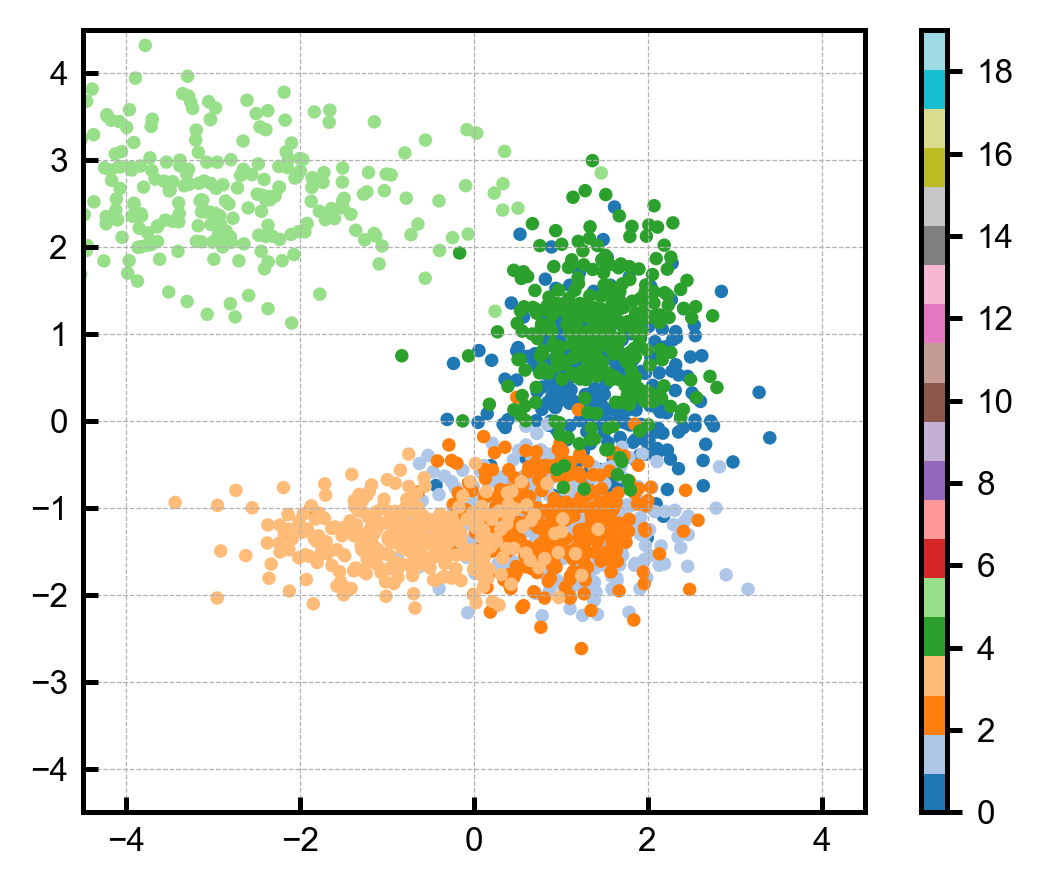

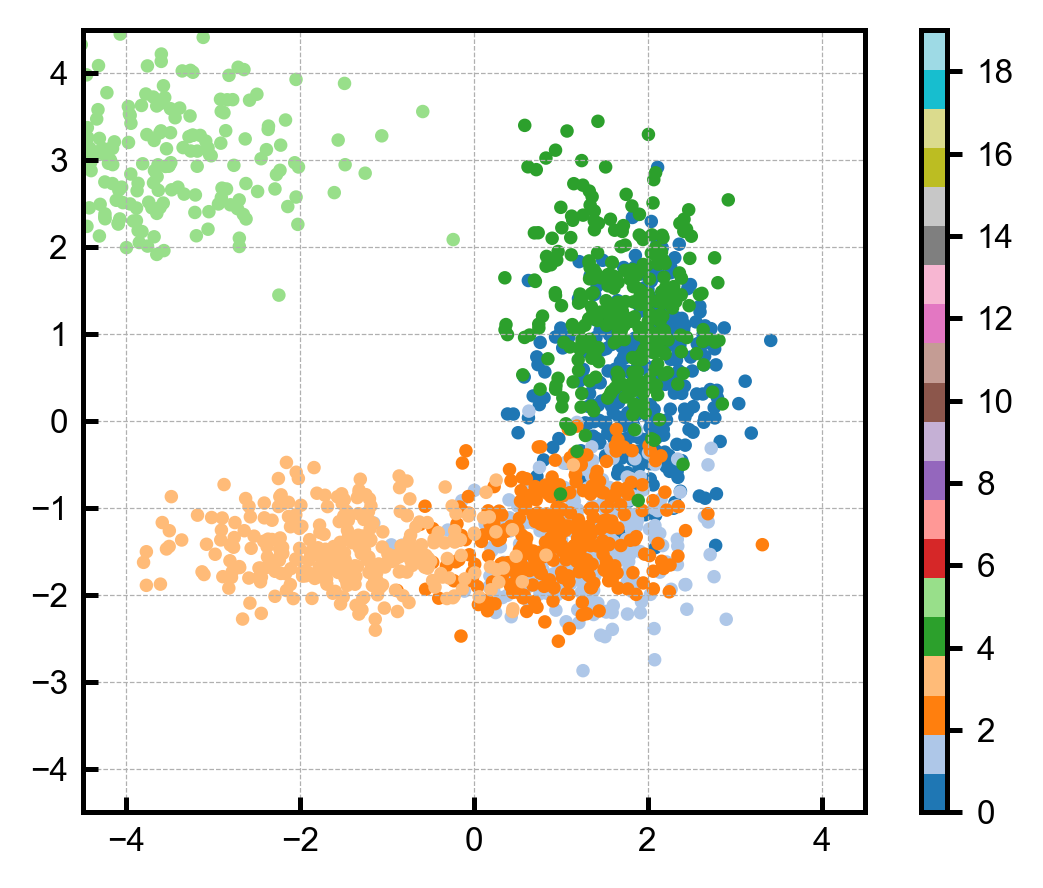

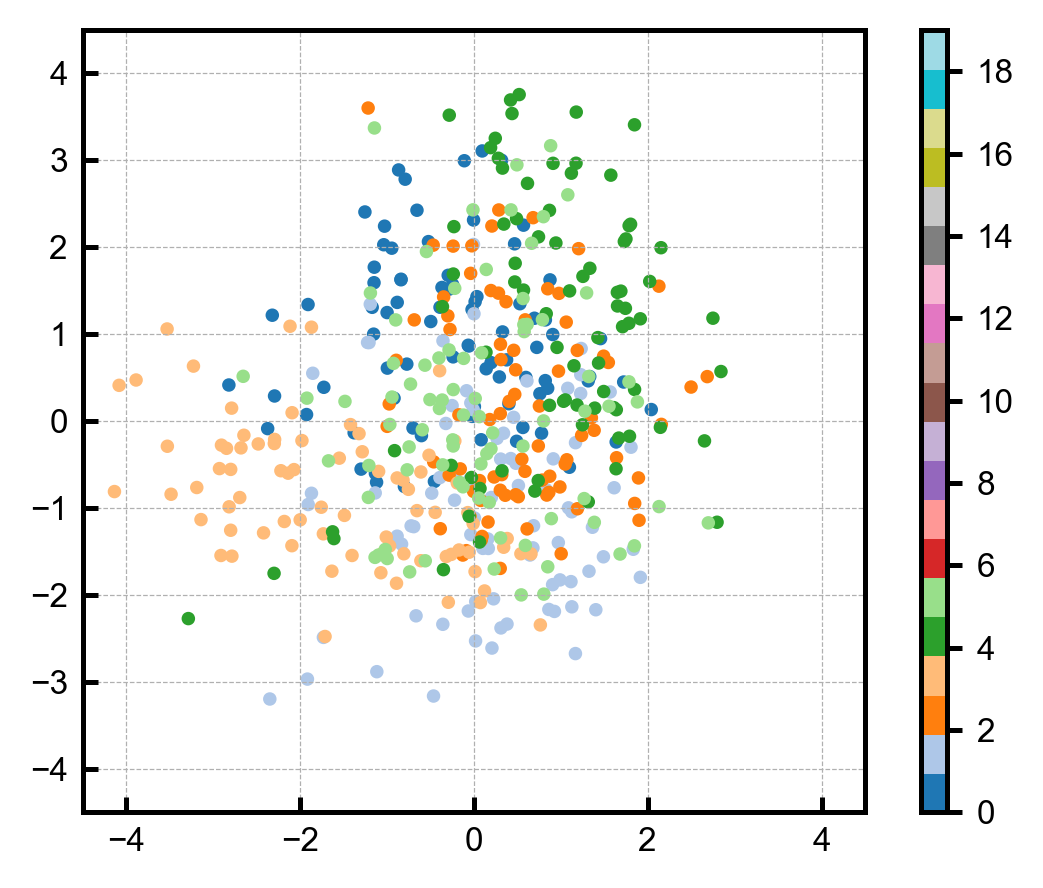

In [13]:
main(args)